# Example 02: ReDoS Attacks
In this example we will evaluate the `libmata` library and its resistance towards ReDoS attacks when used for validating input strings based on regular expressions.

ReDoS attacks are quite common and pervasive in today's software, we can e.g. mention the StackOverflow outage, or other vulnerable regular expressions, that are available in public libraries (e.g. [email validation regex](https://regexlib.com/REDetails.aspx?regexp_id=1757)). Some approaches, that are inefficient, can lead to ReDoS, when they are fed particulary constructed string that forces quadratic number of backtracking in the matching algorithm.

In this example, we will test the library on one of these regexes and on seleted malicious strings.

#### Setup
We will be using `libmata` library, `timeit` for timing of the matching phase, and `seaborn` library for visualizing the result.

In [1]:
import libmata as mata
import timeit
import seaborn
import pandas

#### Helper functions
Through the example we will use the following function to translate string to integer symbols. Since, we are not using any predefined alphabet, we will translate the symbols ourselves.

In [2]:
def translate_string(string: str) -> list[int]:
    """Translates the given string to list of integer symbols
    
    :param str string: translated string
    :return: list of integers
    """
    return [ord(c) for c in string]

#### Creating automaton for vulnerable regular expression

We will use the regular expression from the following source: [email validation regex](https://regexlib.com/REDetails.aspx?regexp_id=1757))

The main issue of the regular expression is, that it contains nested repetitions. These nested repetition then can lead to potential quadratic number of backtracing, when matching non-accepted string.

We construct automaton using underlying `re2` library. We minimize and determinize the results.

We omit the display of the result, since the resulting automaton is quite large. You can use the following to display the result:

    mata.plot(lhs)

In [3]:
lhs = mata.Nfa.from_regex("^([a-zA-Z0-9])(([\\-.]|[_]+)?([a-zA-Z0-9]+))*(@){1}[a-z0-9]+[.]{1}(([a-z]{2,3})|([a-z]{2,3}[.]{1}[a-z]{2,3}))$")
lhs = mata.Nfa.minimize(mata.Nfa.determinize(lhs))

#### Trying simple inputs
First we will try accepted string. We check that valid email address `test@gmail.com` is in the language of the automaton.

Further, we will time the `10000` executions of the matching algorithm, to measure how long the matching case takes.

In [4]:
mata.Nfa.is_in_lang(lhs, translate_string("test@gmail.com"))

True

In [5]:
timeit.timeit(lambda: mata.Nfa.is_in_lang(lhs, translate_string("test@gmail.com")))

2.8624168999995163

Next, we will try the non-accepted string. We check that invalid email address `testtgmaillcom` is not in the language of the automaton. Since, the string does not contain `@` nor `.` the matching can be potentially forced to backtrack.

Again, we will time the `10000` executions of the matching algorithm, to measure how long the matching case takes. We can, see that the time does not differ that much between accepted and non-accepted string. In our experience, these non-matching cases already lead to performance degradation of even one order of magnitude.

In [6]:
mata.Nfa.is_in_lang(lhs, translate_string("testtgmaillcom"))

False

In [7]:
timeit.timeit(lambda: mata.Nfa.is_in_lang(lhs, translate_string("testtgmaillcom")))

2.5593202999989444

####  Measuring the speed of the matching invalid email addresses
In order to test more thoroughly whether `libmata` is not vulnerable against ReDoS attacks, we will measure invalid workloads (i.e. not accepted by automaton) with increased size. We repeat each matching just `10` times (knowing the threat to stability and validity), however, since this is only a rough experiment, we believe it wills suffice.

We plot the result in linear plot.

In [12]:
dataset = {'time': [], 'size': []}
for i in range(0, 1000):
    workload = "testtgmaillcom" + "a"*i
    time = timeit.timeit(lambda: mata.Nfa.is_in_lang(lhs, translate_string(workload)), number=10)
    if float(time):
        dataset['time'].append(float(time))
        dataset['size'].append(len(workload))
dataset = pandas.DataFrame(dataset)
assert dataset.empty

AssertionError: 

<AxesSubplot: xlabel='size', ylabel='time'>

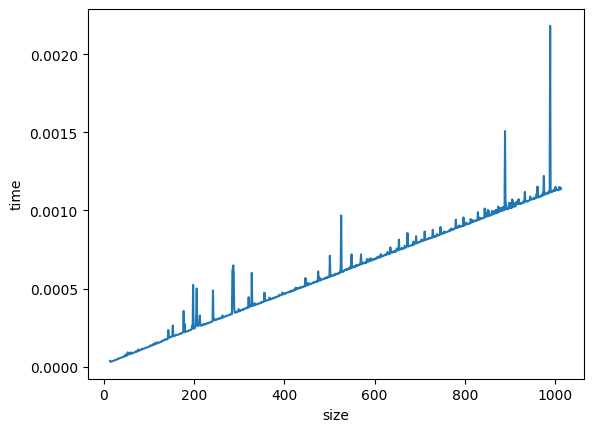

In [9]:
seaborn.lineplot(data=dataset, x="size", y="time")

While, the results are quite unstable, we can still see that the matching of non-valid strings is still linear w.r.t size of the input. The `libmata` library is thus probably not vulnarable against ReDoS attacks (though more complex experiments are, sure, needed).